In [3]:
!pip install --upgrade "cuda-python>=12.6.2"
!pip install kagglehub numpy torch torchvision facenet_pytorch matplotlib seaborn torchinfo pylibraft-cu12==25.2.* rmm-cu12==25.2.* --no-deps

In [4]:
import os
import torch
import random
import warnings
import kagglehub
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
warnings.filterwarnings("ignore", category=FutureWarning, message=".*weights_only=False.*")
mtcnn = MTCNN(
    image_size=160,
    margin=14,
    device="cpu",
    selection_method='center_weighted_size'
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using PyTorch device:", device)

Using PyTorch device: cuda


In [5]:
def prepare_dataset(split=0.9):
    path = kagglehub.dataset_download("dimarodionov/vggface2")
    root_folder = os.path.join(path, "train")
    data = {}
    folder_counts = {}
    for folder in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder)
        if os.path.isdir(folder_path):
            images = [img for img in os.listdir(folder_path) 
                      if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if images:
                data[folder] = images
                folder_counts[folder] = len(images)

    # Rest of the summary printing remains the same
    print("\nDataset Summary:")
    print(f"Total Number of Identities: {len(data)}")
    print(f"Total Number of Images: {sum(len(imgs) for imgs in data.values())}")
    print(f"Min images per folder: {min(len(imgs) for imgs in data.values())}")
    print(f"Max images per folder: {max(len(imgs) for imgs in data.values())}")
    print(f"Average images per folder: {sum(len(imgs) for imgs in data.values()) / len(data):.2f}")

    folders = list(data.keys())
    num_train = int(len(folders) * split)
    random.shuffle(folders)
    train_list, test_list = {}, {}
    
    for folder in folders[:num_train]:
        train_list[folder] = data[folder]
    for folder in folders[num_train:]:
        test_list[folder] = data[folder]
    
    print(f"\nSplit Summary:")
    print(f"Total classes in training list: {len(train_list)}")
    print(f"Total classes in testing list: {len(test_list)}")
    del data, path, num_train, folders, 
    return train_list, test_list, root_folder, folder_counts

In [6]:
train_list, val_list, ROOT, folder_counts = prepare_dataset(split=0.9)


Dataset Summary:
Total Number of Identities: 8631
Total Number of Images: 3141890
Min images per folder: 87
Max images per folder: 843
Average images per folder: 364.02

Split Summary:
Total classes in training list: 7767
Total classes in testing list: 864


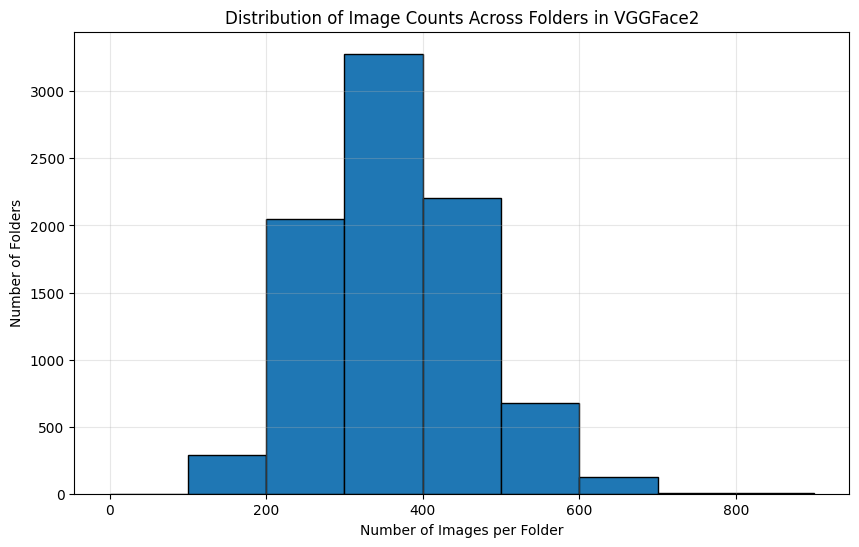

In [7]:
def plot_distribution(folder_counts):
    image_counts = list(folder_counts.values())
    bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    plt.figure(figsize=(10, 6))
    plt.hist(image_counts, bins=bins, edgecolor='black')
    plt.title('Distribution of Image Counts Across Folders in VGGFace2')
    plt.xlabel('Number of Images per Folder')
    plt.ylabel('Number of Folders')
    plt.grid(True, alpha=0.3)
    plt.savefig('bar_chart.png', dpi=600, bbox_inches='tight')
    del image_counts, bins
    plt.show()
plot_distribution(folder_counts)

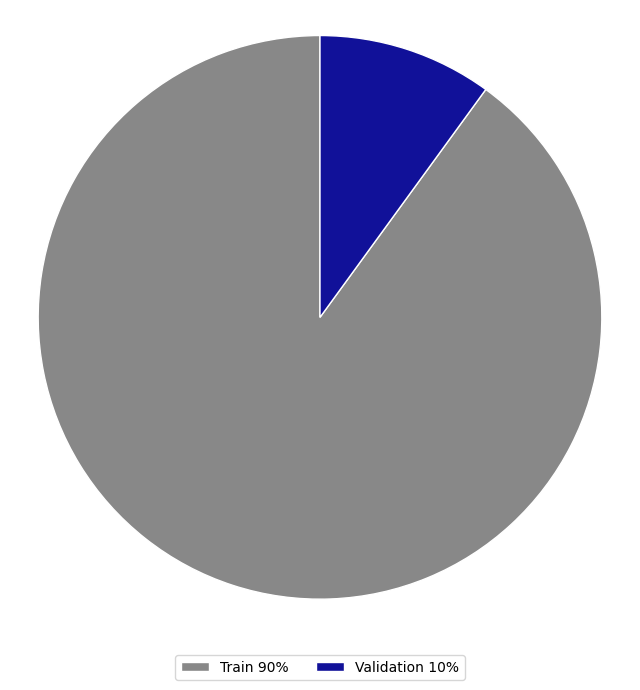

In [8]:
def train_test_plot():
    bin_counts = [7767, 864]
    labels = ['Train 90%', "Validation 10%"]
    colors = [
        '#888888',  
        '#111199'
    ]
    
    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        bin_counts,
        colors=colors,
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
    plt.legend(
        labels=labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,
        fontsize=10
    )
    plt.axis('equal')
    plt.savefig('train_test_pie.png', dpi=600, bbox_inches='tight')
    del bin_counts, labels,colors
    plt.show()
train_test_plot()

In [9]:
def create_random_transform():
    return transforms.Compose([
        #transforms.RandomHorizontalFlip(p=random.random()),
        #transforms.RandomRotation(degrees=random.uniform(0, 10)),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ])

In [10]:
# def load_image(image_path, augment=False, shared_transform=None):
#     try:
#         img = Image.open(image_path).convert('RGB')
#     except:
#         return None
#     face_tensor = mtcnn(img)
#     if face_tensor is None:
#         return None
#     if augment:
#         face_unnorm = (face_tensor * 128.0 + 127.5).clamp(0, 255).byte()
#         face_pil = transforms.ToPILImage()(face_unnorm)
#         if shared_transform is not None:
#             face_augmented = shared_transform(face_pil)
#         else:
#             transform = create_random_transform()
#             face_augmented = transform(face_pil)
#         tensor = transforms.ToTensor()(face_augmented)
#         tensor = fixed_image_standardization(tensor)
#         return tensor
#     else:
#         return face_tensor

In [11]:
def load_image(image_path, augment=False, shared_transform=None):
    try:
        img = Image.open(image_path).convert('RGB')
    except:
        return None
    face_tensor = mtcnn(img)
    if face_tensor is None:
        return None
    if augment:
        pass
    
#     face_unnorm = (face_tensor * 128.0 + 127.5).clamp(0, 255).byte()
#     face_pil = transforms.ToPILImage()(face_unnorm)
#     if shared_transform is not None:
#         face_augmented = shared_transform(face_pil)
#     else:
#         transform = create_random_transform()
#         face_augmented = transform(face_pil)
#     tensor = transforms.ToTensor()(face_augmented)
#     tensor = fixed_image_standardization(tensor)
#     return tensor
# else:
    return face_tensor

In [12]:
def generate_triplets(data, ROOT ,max_triplets=10):
    people = list(data.keys())
    total_triplets = 0
    
    for person in people:
        images = [os.path.join(ROOT, person, f) for f in data[person]]
        total_pairs = min(max_triplets, (len(images) * (len(images) - 1)) // 2)
        pairs = set()
        tries = 0
        max_tries = total_pairs * 10
        while len(pairs) < total_pairs and tries < max_tries:
            anchor_path, pos_path = random.sample(images, 2)
            pair = tuple(sorted([anchor_path, pos_path]))  # Sort to avoid duplicates
            pairs.add(pair)
            tries += 1
        
        for anchor_path, pos_path in pairs:
            neg_person = random.choice([p for p in people if p != person])
            neg_path = random.choice([os.path.join(ROOT, neg_person, f) for f in data[neg_person]])
            shared_transform = create_random_transform()
            negative_transform = create_random_transform()
            anchor = load_image(anchor_path, augment=True, shared_transform=shared_transform)
            positive = load_image(pos_path, augment=True, shared_transform=shared_transform)
            negative = load_image(neg_path, augment=True, shared_transform=negative_transform)
            if anchor is not None and positive is not None and negative is not None:
                total_triplets += 1
                yield (anchor, positive, negative)
    
    print(f"Total training triplets generated: {total_triplets}")

In [13]:
train_generator = generate_triplets(train_list, ROOT, max_triplets=2)

In [14]:
train_data = list(train_generator)

Total training triplets generated: 15495


In [15]:
def create_pairs(data, ROOT, max_pairs=50):
    people = list(data.keys())
    total_pairs = 0
    for person in people:
        images = [os.path.join(ROOT, person, f) for f in data[person]]
        num_positive = min(max_pairs // 2, (len(images) * (len(images) - 1)) // 2)
        positive_pairs = set()
        while len(positive_pairs) < num_positive:
            img1_path, img2_path = random.sample(images, 2)
            pair = tuple(sorted([img1_path, img2_path]))
            positive_pairs.add(pair)
        num_negative = max_pairs - num_positive
        negative_pairs = set()
        while len(negative_pairs) < num_negative:
            img1_path = random.choice(images)
            neg_person = random.choice([p for p in people if p != person])
            img2_path = random.choice([os.path.join(ROOT, neg_person, f) for f in data[neg_person]])
            pair = tuple(sorted([img1_path, img2_path]))
            negative_pairs.add(pair)

        #1 --> positive  ,,, 0 --> negative
        all_pairs = [(pair, 1) for pair in positive_pairs] + [(pair, 0) for pair in negative_pairs]
        for paths, label in all_pairs:
            path1, path2 = paths
            img1 = load_image(path1, augment=False)
            img2 = load_image(path2, augment=False)
            if img1 is not None and img2 is not None:
                total_pairs += 1
                yield ((img1, img2), label)
    
    print(f"Total Testing Pairs generated: {total_pairs}")

In [16]:
val_generator = create_pairs(val_list, ROOT, max_pairs=8)

In [17]:
val_pairs_labels = list(val_generator)

Total Testing Pairs generated: 6897


In [18]:
def get_batch(generator, batch_size=50, min_batch=2):
    batch = []
    for item in generator:
        batch.append(item)
        if len(batch) == batch_size:
            if len(batch[0]) == 3:
                anchor = torch.stack([t[0] for t in batch])
                positive = torch.stack([t[1] for t in batch])
                negative = torch.stack([t[2] for t in batch])
                yield [anchor, positive, negative]
            else:  # Pairs
                img1 = torch.stack([p[0][0] for p in batch])
                img2 = torch.stack([p[0][1] for p in batch])
                labels = torch.tensor([p[1] for p in batch], device=device)
                yield [img1, img2, labels]
            batch = []
    if len(batch) >= min_batch:  # Fixed comparison
        if len(batch[0]) == 3:
            anchor = torch.stack([t[0] for t in batch])
            positive = torch.stack([t[1] for t in batch])
            negative = torch.stack([t[2] for t in batch])
            yield [anchor, positive, negative]
        else:
            img1 = torch.stack([p[0][0] for p in batch])
            img2 = torch.stack([p[0][1] for p in batch])
            labels = torch.tensor([p[1] for p in batch], device=device)
            yield [img1, img2, labels]

In [19]:
class Encoder(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.backbone = nn.Sequential(
            pretrained_model.conv2d_1a,
            pretrained_model.conv2d_2a,
            pretrained_model.conv2d_2b,
            pretrained_model.maxpool_3a,
            pretrained_model.conv2d_3b,
            pretrained_model.conv2d_4a,
            pretrained_model.conv2d_4b,
            pretrained_model.repeat_1,
            pretrained_model.mixed_6a,
            pretrained_model.repeat_2,
            pretrained_model.mixed_7a,
            pretrained_model.repeat_3,
            pretrained_model.block8,
            pretrained_model.avgpool_1a,
            nn.Flatten()
        )
        
        # Custom projection head
        self.projection = nn.Sequential(
            nn.Linear(1792, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.projection(x)
        return F.normalize(x, p=2, dim=1)

def get_encoder(input_shape=(160, 160, 3)):
    pretrained = InceptionResnetV1(classify=False, pretrained='vggface2')
    for param in pretrained.parameters():
        param.requires_grad_(False)
    for param in pretrained.block8.parameters():
        param.requires_grad = True
    return Encoder(pretrained).to(device)
encoder = get_encoder()
summary(encoder, (1, 3, 160, 160))

  0%|          | 0.00/107M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
Encoder                                            [1, 512]                  --
├─Sequential: 1-1                                  [1, 1792]                 --
│    └─BasicConv2d: 2-1                            [1, 32, 79, 79]           --
│    │    └─Conv2d: 3-1                            [1, 32, 79, 79]           (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 79, 79]           (64)
│    │    └─ReLU: 3-3                              [1, 32, 79, 79]           --
│    └─BasicConv2d: 2-2                            [1, 32, 77, 77]           --
│    │    └─Conv2d: 3-4                            [1, 32, 77, 77]           (9,216)
│    │    └─BatchNorm2d: 3-5                       [1, 32, 77, 77]           (64)
│    │    └─ReLU: 3-6                              [1, 32, 77, 77]           --
│    └─BasicConv2d: 2-3                            [1, 64, 77, 77]           --
│    │    └─Conv2d: 3-7

In [20]:
def distance(embeddings1, embeddings2, distance_metric=1):
    if distance_metric == 0:  # Euclidean distance
        diff = torch.substract(embeddings1, embeddings2)
        dist = torch.sum(diff ** 2, dim=1)
    elif distance_metric == 1:  # Cosine similarity
        dots = torch.sum(embeddings1 * embeddings2, dim=1)
        norms = torch.norm(embeddings1, dim=1) * torch.norm(embeddings2, dim=1)
        dist = torch.clamp(1 - (dots / norms), 0, 2)
    else:
        raise ValueError(f"Undefined distance metric {distance_metric}")
    return dist

In [21]:
def train_model(encoder, train_generator, batch_size=50, epochs=10, lr=0.001):
    encoder = encoder.to(device)
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, encoder.parameters()), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=500, cycle_momentum=False, mode='exp_range', gamma=0.999)
    best_loss = float('inf')
    best_accuracy = 0.0
    triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, swap=True)
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        encoder.train()
        train_loss = 0
        correct_predictions = 0
        total_triplets = 0
        num_batches = 0
        for batch in get_batch(train_generator, batch_size):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            optimizer.zero_grad()
            
            anchor_emb = encoder(anchor)
            positive_emb = encoder(positive)
            negative_emb = encoder(negative)
            loss = triplet_loss(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), 2.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            
            with torch.no_grad():
                pos_dist = distance(anchor_emb, positive_emb ,distance_metric=1)
                neg_dist = distance(anchor_emb, negative_emb, distance_metric=1)
                correct_predictions += torch.sum(pos_dist < neg_dist).item()
                total_triplets += anchor_emb.size(0)
            num_batches += 1
        avg_train_loss = train_loss / num_batches if num_batches > 0 else 0
        accuracy = correct_predictions / total_triplets if total_triplets > 0 else 0
        train_losses.append(avg_train_loss)
        train_accuracies.append(accuracy)
        if (avg_train_loss < best_loss) or (avg_train_loss == best_loss and accuracy > best_accuracy):
            best_loss = avg_train_loss
            best_accuracy = accuracy
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {accuracy:.4f}\n")
        torch.cuda.empty_cache()
    return encoder, train_losses, train_accuracies

In [22]:
def evaluate_model(encoder, val_generator, batch_size=16, find_optimal_threshold=True):
    encoder.to(device).eval()
    distances = []
    true_labels = []
    
    with torch.no_grad():
        for batch in get_batch(val_generator, batch_size):
            img1, img2, label = batch
            if len(img1) == 0 or len(img2) == 0:
                continue
            img1 = img1.to(device)
            img2 = img2.to(device)
            
            emb1 = encoder(img1)
            emb2 = encoder(img2)
            
            dist = distance(emb1, emb2, distance_metric=1)
            
            distances.extend(dist.cpu().numpy())
            true_labels.extend(label.cpu().numpy())

    distances = np.array(distances)
    actual_issame = np.asarray(true_labels, dtype=bool)
    # Add this check
    if len(distances) != len(actual_issame):
        raise ValueError(f"Mismatched lengths: distances {len(distances)} vs labels {len(actual_issame)}")
    # ROC analysis
    fpr, tpr, thresholds = roc_curve(actual_issame, -distances)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = -thresholds[optimal_idx]
    
    # Calculate metrics
    pred_issame = distances <= optimal_threshold
    tp = np.sum(pred_issame & actual_issame)
    fp = np.sum(pred_issame & ~actual_issame)
    tn = np.sum(~pred_issame & ~actual_issame)
    fn = np.sum(~pred_issame & actual_issame)
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # 1. Distance Distribution
    plt.subplot(131)
    plt.hist(distances[actual_issame], bins=50, alpha=0.5, 
             label=f'Genuine (μ={np.mean(distances[actual_issame]):.2f})')
    plt.hist(distances[~actual_issame], bins=50, alpha=0.5, 
             label=f'Impostor (μ={np.mean(distances[~actual_issame]):.2f})')
    plt.axvline(optimal_threshold, color='r', linestyle='--', 
                label=f'Threshold={optimal_threshold:.2f}')
    plt.xlabel('Cosine Distance (0=identical)')
    plt.ylabel('Count')
    plt.legend()
    
    # 2. ROC Curve
    plt.subplot(132)
    plt.plot(fpr, tpr, label=f'AUC={np.trapz(tpr, fpr):.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='r', 
                label=f'Optimal (FPR={fpr[optimal_idx]:.3f}, TPR={tpr[optimal_idx]:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    # 3. Threshold Analysis
    plt.subplot(133)
    plt.plot(-thresholds, tpr, label='TPR')
    plt.plot(-thresholds, fpr, label='FPR')
    plt.axvline(optimal_threshold, color='r', linestyle='--')
    plt.xlabel('Threshold (Distance)')
    plt.ylabel('Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics
    metrics = {
        'accuracy': (tp + tn) / len(actual_issame),
        'tpr': tp / (tp + fn + 1e-8),
        'fpr': fp / (fp + tn + 1e-8),
        'threshold': optimal_threshold,
        'auc': np.trapz(tpr, fpr),
        'distance_stats': {
            'genuine_mean': np.mean(distances[actual_issame]),
            'impostor_mean': np.mean(distances[~actual_issame]),
            'min': np.min(distances),
            'max': np.max(distances)
        }
    }
    
    # Print metrics in a readable format
    print("\nVerification Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    print(f"True Positive Rate: {metrics['tpr']:.2%}")
    print(f"False Positive Rate: {metrics['fpr']:.2%}")
    print(f"Optimal Threshold: {metrics['threshold']:.4f}")
    print(f"AUC: {metrics['auc']:.3f}")
    print("\nDistance Statistics:")
    print(f"Genuine mean: {metrics['distance_stats']['genuine_mean']:.4f}")
    print(f"Impostor mean: {metrics['distance_stats']['impostor_mean']:.4f}")
    print(f"Minimum distance: {metrics['distance_stats']['min']:.4f}")
    print(f"Maximum distance: {metrics['distance_stats']['max']:.4f}")
    
    return metrics

In [23]:
def plot_metrics(losses, accuracies, save_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(losses) + 1), losses, 'b-', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(accuracies) + 1), accuracies, 'r-', marker='o')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_name, dpi=600, bbox_inches='tight')
    plt.show()

In [24]:
encoder, train_losses, train_accuracies = train_model(encoder, train_data, batch_size=64, epochs=10, lr=0.05)

Epoch 1/10, Train Loss: 0.6702, Train Accuracy: 0.9835

Epoch 2/10, Train Loss: 0.6630, Train Accuracy: 0.9837

Epoch 3/10, Train Loss: 0.6523, Train Accuracy: 0.9845

Epoch 4/10, Train Loss: 0.6461, Train Accuracy: 0.9852

Epoch 5/10, Train Loss: 0.6443, Train Accuracy: 0.9851

Epoch 6/10, Train Loss: 0.6416, Train Accuracy: 0.9852

Epoch 7/10, Train Loss: 0.6372, Train Accuracy: 0.9857

Epoch 8/10, Train Loss: 0.6344, Train Accuracy: 0.9858

Epoch 9/10, Train Loss: 0.6335, Train Accuracy: 0.9859

Epoch 10/10, Train Loss: 0.6324, Train Accuracy: 0.9860



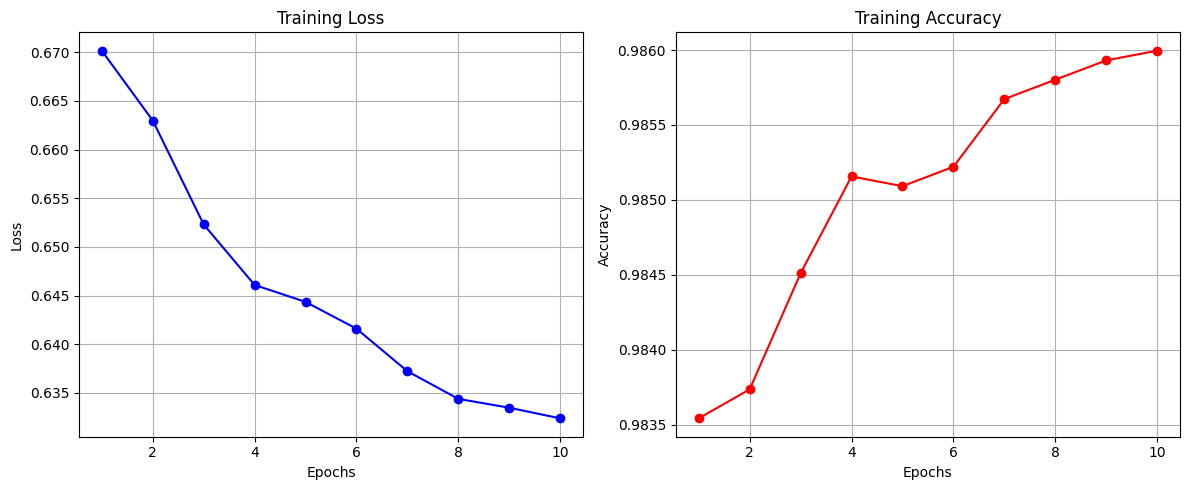

In [26]:
plot_metrics(train_losses, train_accuracies, 'Train_plot.png')

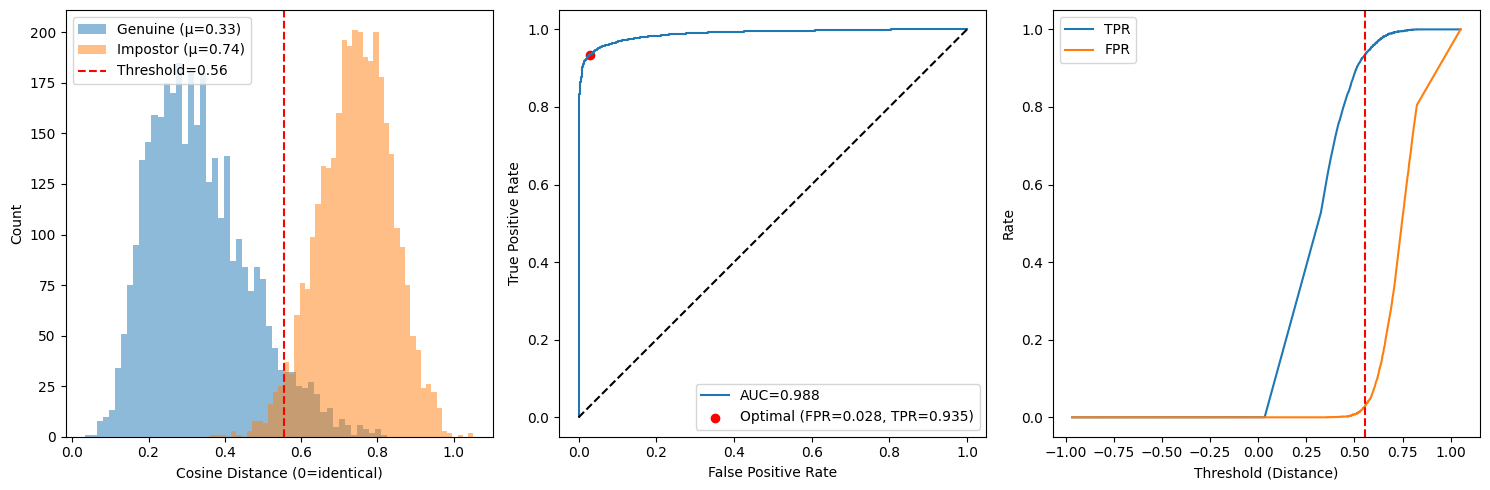


Verification Metrics:
Accuracy: 95.33%
True Positive Rate: 93.48%
False Positive Rate: 2.81%
Optimal Threshold: 0.5552
AUC: 0.988

Distance Statistics:
Genuine mean: 0.3349
Impostor mean: 0.7426
Minimum distance: 0.0338
Maximum distance: 1.0516


In [27]:
result1 = evaluate_model(encoder, val_pairs_labels, batch_size=256)

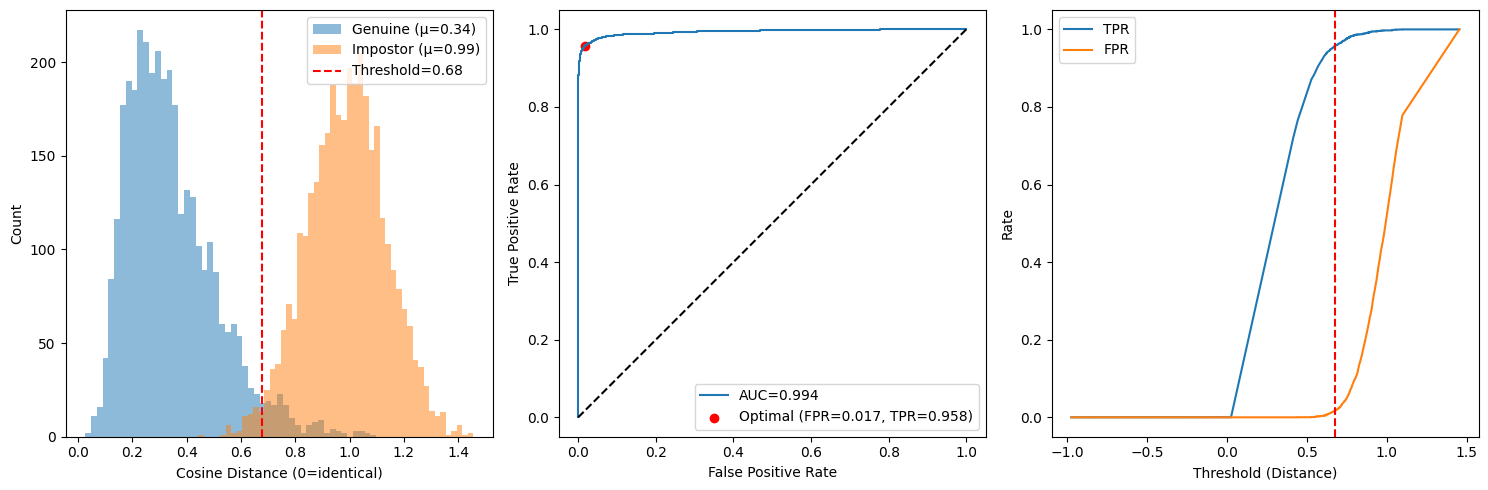


Verification Metrics:
Accuracy: 97.09%
True Positive Rate: 95.82%
False Positive Rate: 1.65%
Optimal Threshold: 0.6773
AUC: 0.994

Distance Statistics:
Genuine mean: 0.3427
Impostor mean: 0.9889
Minimum distance: 0.0253
Maximum distance: 1.4549


In [30]:
model = InceptionResnetV1(classify=False, pretrained='vggface2')
result2 = evaluate_model(model, val_pairs_labels, batch_size=256)